# Phân cụm văn bản báo tiếng việt

## Cài đặt và import các thư viện cần thiết

In [1]:
!pip install -qq pyvi sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00


In [2]:
import json
import requests
import re
import torch
import numpy as np
from pprint import pprint
from pyvi import ViTokenizer
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
# Kiểm tra GPU có khả dụng không
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cpu':
    raise RuntimeError("No GPU found")

print(f'Using device: {device}')

Using device: cuda


## Tiền sử lý dữ liệu

### Tải bộ văn bản báo tiếng việt về

In [6]:
with open('6_cats_2.json','r',encoding='utf-8') as f:
    data = json.load(f)

In [19]:
data[800]

{'url': 'https://dantri.com.vn/suc-khoe/doi-5-nam-de-cat-amidan-nao-va-cho-con-20230823065951314.htm',
 'title': 'Đợi 5 năm để cắt amidan, nạo VA cho con',
 'description': 'Đó là trường hợp của chị P.T.H, mẹ của bé N.Q.V (5 tuổi, Hà Nội) bị viêm amidan, VA tái phát nhiều lần trong năm, ảnh hưởng tới sức khỏe và cuộc sống của bé. Tuy nhiên, chị H. phải chờ tới khi bé V. đủ 5 tuổi mới có thể phẫu thuật.',
 'content': 'VA và amidan quá phát, kìm hãm sự phát triển của bé 5 tuổi\nĐược mẹ đưa đến Bệnh viện Đa khoa Quốc tế Thu Cúc TCI vì sốt, đau họng, khó nuốt, ngủ ngáy…, sau thăm khám, bé N.Q.V được TTUT.BS. Dương Văn Tiến - Trưởng phòng khám Tai Mũi Họng chẩn đoán xác định viêm amidan độ 4 và viêm VA độ 3, có chỉ định phẫu thuật.\n[Bé V. được chẩn đoán xác định viêm amidan độ 4 và viêm VA độ 3, có chỉ định phẫu thuật (Ảnh: TCI).]\nTheo chị P.T.H, mẹ bé V: "Đây không phải là lần đầu tiên con sốt, đau họng, khó nuốt, ngủ ngáy,... vì viêm VA. Từ khi chào đời, con đã phải chung sống cùng 2 bện

In [8]:
print("Nội dung: ", data[0]['content'])
print("\nNhãn: ", data[0]['metadata']['cat'])

Nội dung:  Chiều 6/8, đại diện VKSND TP HCM tiếp tục nêu quan điểm đối với vụ án hai cựu cục trưởng Đăng kiểm Việt Nam Đặng Việt Hà, Trần Kỳ Hình cùng 252 bị cáo về 11 tội danh liên quan đến hàng loạt sai phạm trong hoạt động đăng kiểm.
Theo VKS, các bị cáo trong vụ án đều có chuyên môn, nghiệp vụ, nhưng chỉ vì động cơ tư lợi cá nhân, nhận thức chưa đầy đủ, đã thực hiện hành vi phạm tội xuyên suốt từ Cục trưởng, đến trưởng phòng và nhân viên. "Trong đó có bị cáo được hưởng lợi không nhiều, nhưng hành vi ảnh hưởng đến tính mạng người dân, môi trường sống, và niềm tin của nhân dân, nên cần có hình phạt nghiêm khắc để răn đe", đại diện VKS nói.
[Cựu cục trưởng Đặng Việt Hà tại tòa hôm nay. Ảnh: Thanh Tùng]
Về hình phạt, VKS cho rằng cần có sự phân hóa trách nhiệm xử lý nghiêm đối với người đứng đầu, xem xét giảm nhẹ cho các bị cáo có vai trò đồng phạm, thực hiện theo chỉ đạo.
Trong đó, bị cáo Đặng Việt Hà; Trần Anh Quân, cựu trưởng Phòng kiểm định xe cơ giới (VAR) và một số bị cáo thực hi

### Gộp các bài báo theo thể loại

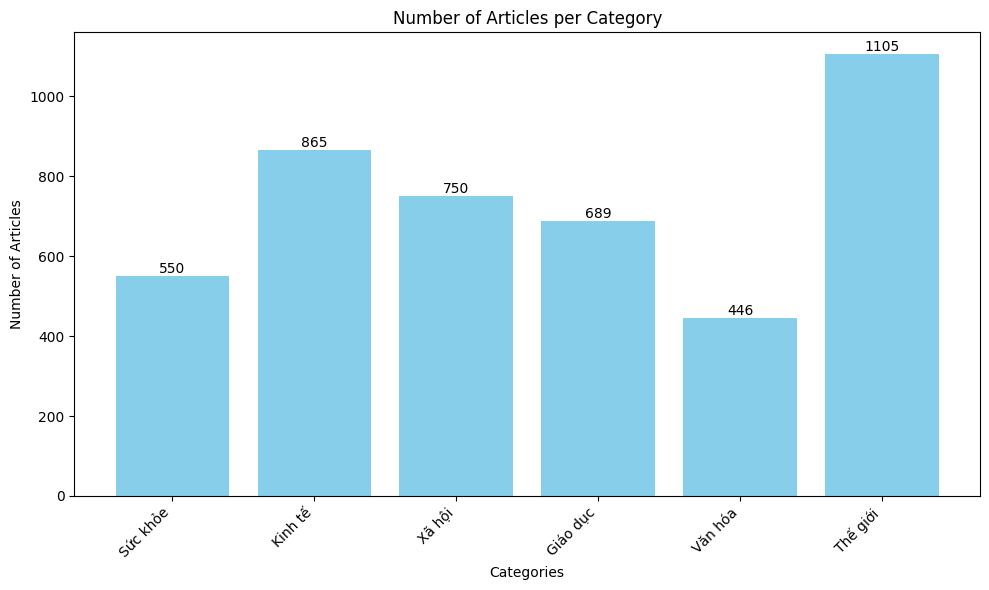

In [20]:
# Nhóm các bài báo theo nhãn
grouped_data = defaultdict(list)
for doc in data:
    cat = doc['metadata']['cat']
    grouped_data[cat].append({'title': doc['title'], 'content': doc['content']})

# Tính số lượng bài báo trong mỗi nhóm
group_counts = {cat: len(contents) for cat, contents in grouped_data.items()}

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(group_counts.keys(), group_counts.values(), color='skyblue')

# Thêm số lượng lên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Categories')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Chọn nhóm các bài báo lĩnh vực kinh tế để phân cụm
economics_data = []

for doc in grouped_data['Kinh tế']:
    economics_data.append(doc['title'] + ' ' + doc['content'])

len(economics_data)

865

### Làm sạch dữ liệu

In [22]:
# Danh sách stop words tiếng Việt (ví dụ)
stop_words = set([
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chứ", "chưa",
    "chuyện", "có", "có_thể", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để",
    "đến", "điều", "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên",
    "lúc", "mà", "một", "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những",
    "nơi", "nữa", "phải", "qua", "ra", "rằng", "rằng", "rất", "rồi", "sau", "sẽ", "so",
    "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và", "vẫn", "vào", "vậy",
    "vì", "việc", "với"
])

### YOUR CODE START HERE ###

def preprocess(text):
    # Tokenize văn bản
    text = ViTokenizer.tokenize(text)
    # Loại bỏ ký tự đặc biệt
    text = re.sub(r'\W', ' ', text)
    # Chuyển về chữ thường
    text = text.lower()
    # Chia văn bản thành list các từ
    words = text.split()
    # Đếm số lượng từ
    original_count = len(words)
    # Loại bỏ stop words
    filtered_words = [word for word in words if word not in stop_words]
    # Đếm số lượng từ sau loại bỏ
    filtered_count = len(filtered_words)
    # Gộp các từ lại thành đoạn
    text = ' '.join(filtered_words)
    # Tính phần trăm stopword đã loại bỏ
    stopword_percentage = (original_count - filtered_count) / original_count * 100
    # Trả ra kết quả
    return text, stopword_percentage

### YOUR CODE END HERE ###


# Tiền xử lý nội dung các bài báo
total_stopword_percentage = 0
texts = []

for doc in tqdm(economics_data, desc="Processing articles"):
    processed_content, stopword_percentage = preprocess(doc)
    texts.append(processed_content)
    total_stopword_percentage += stopword_percentage

average_stopword_percentage = total_stopword_percentage / len(economics_data) * 100

print(f"Average percentage of stop words removed: {average_stopword_percentage:.2f}%")

Processing articles:   0%|          | 0/865 [00:00<?, ?it/s]

Average percentage of stop words removed: 2354.20%


In [23]:
len(texts)

865

In [24]:
print(texts[0])

người phụ_nữ 41 tuổi ở hà_nội_sinh mổ lần thứ 7 chia_sẻ về động_lực sinh tới 7 người con chị h chồng vui_vẻ biết gia_đình thích đông con lần mang thai đều khỏe_mạnh anh_chị sẵn_sàng tiếp_tục sinh bé ở lần mang bầu thứ 7 41 tuổi tiền_sử phẫu_thuật lần 6 lần mổ đẻ 1 lần mổ phụ_khoa chị h còn phát_hiện mắc tiểu_đường thai kỳ khiến tôi lo nhất trong lần mang thai tiểu_đường thai kỳ khả_năng kinh_tế chị chia_sẻ ôm trong tay cậu con_trai chào_đời cân nặng 3 1 kg trao_đổi về trường_hợp đặc_biệt gs ts nguyễn_duy_ánh giám_đốc bệnh_viện phụ_sản trung_ương người trực_tiếp thực_hiện ca mổ biết hàng chục năm làm nghề lần thứ 2 ông thực_hiện ca mổ hy_hữu người mẹ số lần mổ đẻ thế ca mổ đầu_tiên cách 28 năm ông mới nghề bác_sĩ nội_trú cộng_hòa pháp sản_phụ ông mổ lấy thai người phụ_nữ châu phi mổ đẻ lần thứ 7 đẻ_thường nguy_hiểm còn sản_phụ mổ đẻ 7 lần hiếm ca đặc_biệt chúng_tôi quan_tâm làm_sao tốt mẹ bé vui ca mổ thành_công em bé chào_đời khóc to hồng_hào vị chuyên_gia chia_sẻ nhân_viên y_tế bệnh_v

### Trích chọn đặc trưng, tạo vector biểu diễn cho dữ liệu

#### Dùng TF-IDF

In [ ]:
# # Vectorize texts using TF-IDF for SVM
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
# economics_embeddings = tfidf_vectorizer.fit_transform(texts)

# economics_embeddings = economics_embeddings.toarray()
# print(economics_embeddings.shape)

#### Dùng SBert

In [25]:
from sentence_transformers import SentenceTransformer

# Chọn mô hình và chuyển sang GPU
model = SentenceTransformer('keepitreal/vietnamese-sbert', device=device)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
# ví dụ
enc = model.encode('xin chào')
print(enc.shape)
print(enc)

(768,)
[ 4.03795242e-01  5.39230585e-01 -5.04004955e-01 -7.17044532e-01
  1.07035376e-01 -2.92842507e-01 -4.59063277e-02  1.52295336e-01
 -2.34073132e-01 -1.54185295e-01  1.17454842e-01  4.30377156e-01
  9.63170975e-02  1.83036566e-01  7.68422261e-02  1.74694180e-01
  5.25173992e-02 -4.52807955e-02  1.42724961e-01 -6.85165226e-02
 -1.18662894e-01 -6.38732433e-01  4.99835044e-01 -4.58089590e-01
 -9.92413312e-02 -4.88896370e-01 -2.52602864e-02  4.34168354e-02
 -5.65652192e-01  1.12226501e-01  2.30188757e-01  8.20212513e-02
  1.53546184e-02  3.64027530e-01  9.53538418e-01  6.19501233e-01
 -1.63106218e-01  3.23149800e-01  5.45238078e-01  7.96736300e-01
  1.33982956e-01 -2.79224869e-02  7.80682087e-01  9.98717695e-02
 -4.42458615e-02  3.56377810e-02 -2.68451452e-01 -5.08545399e-01
  3.80317271e-02 -3.78402956e-02  9.80229303e-02 -1.67624027e-01
 -2.87251920e-02  4.09534574e-01 -4.92821224e-02  1.77344412e-01
 -2.85189390e-01  3.29363018e-01 -3.32213491e-01  1.07594632e-01
 -2.70091832e-01  

In [27]:
# Tạo vector biểu diễn cho từng bài báo với tiến độ
economics_embeddings = []

for content in tqdm(texts, desc=f"Encoding articles ", unit='article'):
    embedding = model.encode(content)
    economics_embeddings.append(embedding)

Encoding articles :   0%|          | 0/865 [00:00<?, ?article/s]

## Chạy các thuật toán phân cụm

### Hàm đánh giá chất lượng phân cụm

In [28]:
import warnings
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

# Tắt tất cả các cảnh báo FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

def evaluate_clustering(embeddings, labels, model=None):
    sil_score = silhouette_score(embeddings, labels)
    db_score = davies_bouldin_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)

    # Tính WCSS nếu có model KMeans
    wcss = None
    if model and hasattr(model, 'inertia_'):
        wcss = model.inertia_

    return sil_score, db_score, ch_score, wcss

### Hàm chạy thuật toán phân cụm và đánh giá chất lượng phân cụm

In [29]:
# Chạy và đánh giá chất lượng phân cụm
def cluster_and_evaluate(embeddings, n_clusters_list):
    results = {n: {} for n in n_clusters_list}

    for n_clusters in tqdm(n_clusters_list, desc="Clustering and evaluating"):
        # K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)
        kmeans_labels = kmeans.labels_
        results[n_clusters]['kmeans'] = evaluate_clustering(embeddings, kmeans_labels, model=kmeans)

        ### YOUR CODE START HERE ###

        # EM (GMM)
        gmm = GaussianMixture(n_components=n_clusters, random_state=42).fit(embeddings)
        gmm_labels = gmm.predict(embeddings)
        results[n_clusters]['gmm'] = evaluate_clustering(embeddings, gmm_labels)

        # Hierarchical Clustering
        hier = AgglomerativeClustering(n_clusters=n_clusters).fit(embeddings)
        hier_labels = hier.labels_
        results[n_clusters]['hierarchical'] = evaluate_clustering(embeddings, hier_labels)

        ### YOUR CODE END HERE ###

    return results

### Chạy thuật các thuật toán phân cụm

In [30]:
# # Khởi tạo từ điển để ưu kết quả
cluster_results = {}

In [32]:
### YOUR CODE START HERE ###

# Lọc các giá trị n_clusters đã có trong cluster_results
n_clusters_list = range(10, 40, 5)

### YOUR CODE END HERE ###

n_clusters_to_run = [n for n in n_clusters_list if n not in cluster_results]

# Chạy phân cụm và đánh giá với các giá trị n_clusters mới
if n_clusters_to_run:
    new_cluster_results = cluster_and_evaluate(economics_embeddings, n_clusters_to_run)
    # Hợp nhất kết quả mới vào kết quả cũ
    cluster_results.update(new_cluster_results)
else:
    print("All n_clusters in the list have already been evaluated.")

Clustering and evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

### Vẽ biểu đồ

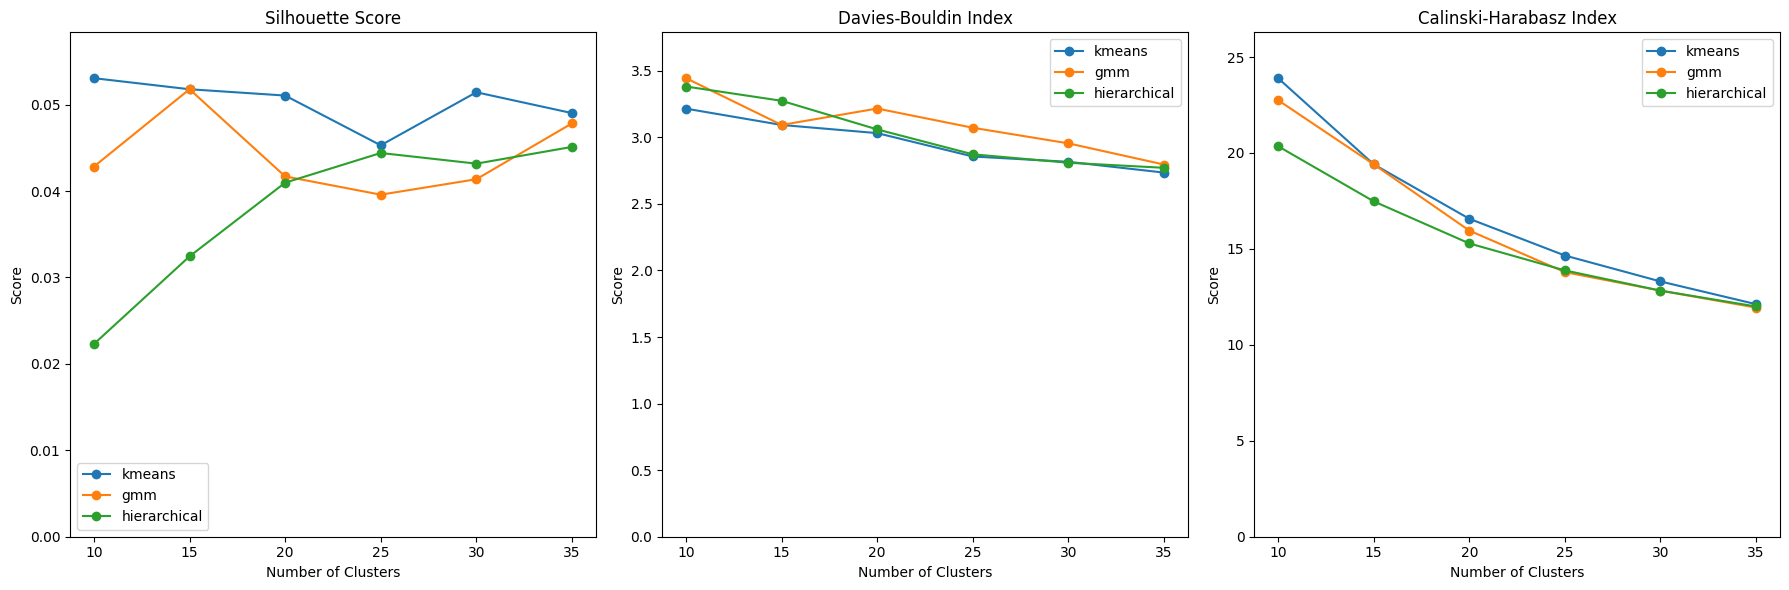

In [33]:
# Hàm vẽ biểu đồ kết quả đánh giá
def plot_evaluation_results(metrics_dict):
    n_clusters_list = sorted(metrics_dict.keys())

    algorithms = ['kmeans', 'gmm', 'hierarchical']
    metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index']

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=False)

    for i, metric in enumerate(metrics):
        ax = axs[i]
        for algo in algorithms:
            scores = [metrics_dict[n][algo][i] for n in n_clusters_list]
            ax.plot(n_clusters_list, scores, marker='o', label=algo)

        ax.set_title(metric)
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Score')
        ax.legend()

        # Đặt giới hạn trục Y cho mỗi metric
        if metric == 'Silhouette Score':
            ax.set_ylim(0, max(max([metrics_dict[n][algo][0] for n in n_clusters_list]) for algo in algorithms) * 1.1)
        elif metric == 'Davies-Bouldin Index':
            ax.set_ylim(0, max(max([metrics_dict[n][algo][1] for n in n_clusters_list]) for algo in algorithms) * 1.1)
        elif metric == 'Calinski-Harabasz Index':
            ax.set_ylim(0, max(max([metrics_dict[n][algo][2] for n in n_clusters_list]) for algo in algorithms) * 1.1)

    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ đánh giá
plot_evaluation_results(cluster_results)

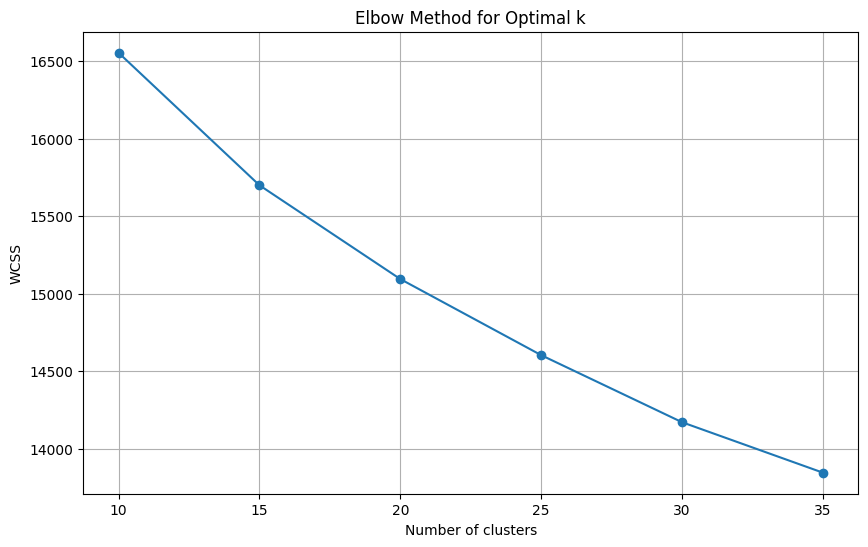

In [34]:
# Vẽ đồ thị Elbow
n_list = sorted(cluster_results.keys())
scores = [cluster_results[n]['kmeans'][3] for n in n_list]

plt.figure(figsize=(10, 6))
plt.plot(n_list, scores, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(n_clusters_list)
plt.grid(True)
plt.show()

### Huấn luyện với số lượng cụm và thuật toán tối ưu

In [37]:
### YOUR CODE START HERE ###

# Lựa chọn số cụm tối ưu
optimal_n_clusters = 15

# Lựa chọn model tối ưu
model = AgglomerativeClustering(n_clusters=optimal_n_clusters).fit(economics_embeddings)

### YOUR CODE END HERE ###

In [38]:
# Huần luyện và lưu nhãn phân cụm
labels = model.fit_predict(economics_embeddings)

### Minh họa việc phát hiện chủ đề

Minh họa phân cụm trên không gian 2 chiều

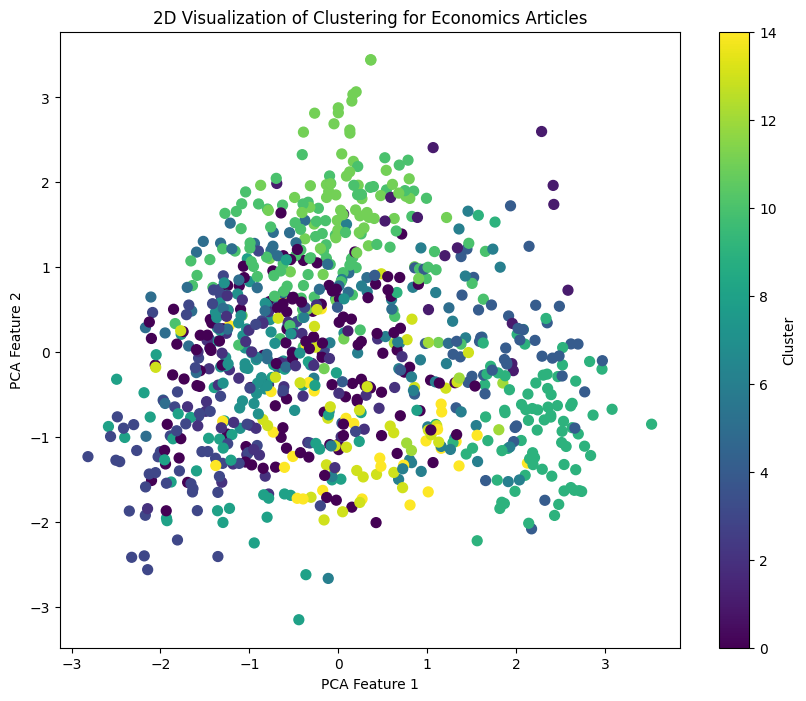

In [39]:
from sklearn.decomposition import PCA

# Giảm chiều dữ liệu xuống 2D bằng PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(economics_embeddings)

# Vẽ minh họa việc phân cụm trên đồ thị 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('2D Visualization of Clustering for Economics Articles')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

Minh họa việc phát hiện chủ đề

In [40]:
# Thay `chosen_cluster` bằng số cụm bạn muốn kiểm tra, số bắt đầu từ 0 đến n_clusters - 1
chosen_cluster = 10

# Lọc các bài báo thuộc cụm đã chọn
chosen_cluster_indices = [i for i, label in enumerate(labels) if label == chosen_cluster]
chosen_articles = [economics_data[i] for i in chosen_cluster_indices]

# In ra nội dung của 3 bài báo đầu tiên trong cụm đã chọn
print(f"Nội dung của 3 bài báo trong cụm {chosen_cluster}:")
for i, article in enumerate(chosen_articles[:3]):
    print(f"Bài báo {i+1}:")
    print(article)
    print("-" * 80)

Nội dung của 3 bài báo trong cụm 10:
Bài báo 1:
Chi phí điều trị một số bệnh ung thư thường gặp, BHYT chi trả ra sao? Sau khi đăng tải bài viết "Bộ trưởng Y tế nói gì về đề nghị hỗ trợ 100% chi phí khám chữa bệnh ung thư?", phản ánh câu trả lời của người đứng đầu ngành y tế trước kiến nghị của cử tri về việc sớm có chính sách hỗ trợ, trợ cấp những người mắc bệnh hiểm nghèo như ung thư, chạy thận, VietNamNet tiếp nhận nhiều ý kiến, chia sẻ của độc giả.
Độc giả giấu tên ủng hộ việc nên hỗ trợ những trường hợp bệnh nan y như ung thư, suy thận bởi họ "suy kiệt về cả tinh thần lẫn kinh tế". Trong khi độc giả Quyết Thanh cho rằng với những người mắc bệnh ung thư hay chạy thận mà không có BHYT thì mong nhà nước xem xét cho họ có chế độ bảo hiểm giống việc hỗ trợ các gia đình nghèo.
"Gia đình nào có người mắc các bệnh nan y này cũng không khác gì hộ nghèo", độc giả để lại lời bình luận sau bài viết.
Bộ trưởng Y tế Đào Hồng Lan cho biết theo quy định của pháp luật BHYT, người bệnh được thanh to

## Bài tập về nhà
Tìm hiểu thuật toán phân cụm dựa theo mật độ. Tạo một notebook mới, cài đặt và chạy thuật toán tìm hiểu được trên bộ dữ liệu văn bản báo tiếng việt (ở bên trên), in ra các metrics Silhouette Score, Davies-Bouldin Index và Calinski-Harabasz Index. Nộp lại notebook và đưa ra kết luận về hiệu quả của thuật toán so với các thuật toán đã chạy trong bài thực hành.